In [1]:
from __future__ import annotations

%load_ext jupyter_black

In [2]:
import os
from typing import Any

import numpy as np
import xarray as xr

from mesoscaler.core import Mesoscale, P0, DependentDataset
from mesoscaler.enums import (
    # - independent variables
    Dimensions,
    Coordinates,
    # - dependent variables
    URMA,
    ERA5,
    # Era5
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
    # URMA
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
    SURFACE_PRESSURE,
)

_test_data = "../tests/data"

urma_store = os.path.join(_test_data, "urma.zarr")
era5_store = os.path.join(_test_data, "era5.zarr")

print("\n".join(f"{t.__name__} = {tuple(t)}" for t in (Dimensions, Coordinates, URMA, ERA5)))

Dimensions = (T, Z, Y, X)
Coordinates = (time, vertical, latitude, longitude)
URMA = (total_cloud_cover, ceiling, u_wind_component_10m, v_wind_component_10m, wind_speed_10m, wind_speed_gust, wind_direction_10m, temperature_2m, dewpoint_temperature_2m, specific_humidity_2m, surface_pressure, visibility, orography)
ERA5 = (geopotential, specific_humidity, temperature, u_component_of_wind, v_component_of_wind, vertical_velocity)


In [3]:
# define the variables and levels
pressure_levels = [P0, 1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]
era5_dvars = [
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
]
urma_dvars = [
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
]
assert len(era5_dvars) == len(urma_dvars), "vard must be the same length in order to be resampled"
scale = Mesoscale(200, 200, pressure=pressure_levels, rate=20)  # create scale object
era5 = DependentDataset.from_zarr(era5_store, era5_dvars)  # get datasets
urma = DependentDataset.from_zarr(urma_store, urma_dvars)  # get datasets

In [4]:
print(
    era5.to_array().shape,
    urma.to_array().shape,
    scale.hpa.shape,
    sep="\n",
)

(5, 2, 37, 721, 1440)
(5, 2, 1, 1597, 2345)
(7,)


In [5]:
a = np.stack([era5[dvar].to_numpy() for dvar in era5.data_vars])
a.shape  # (Variable, Time, Level, Latitude, Longitude)

(5, 2, 37, 721, 1440)

In [6]:
time = era5.time.to_numpy()
start, stop = time

In [7]:
# scott afb
longitude = -89.835
latitude = 38.54

sampler = scale.resample(urma, era5, height=150, width=200)
arr = sampler.nearest(longitude, latitude, time=np.s_[start:stop])  # (channel, T, Z, Y, X)
a.shape

(5, 2, 37, 721, 1440)

In [8]:
(
    xr.DataArray(
        arr,
        dims=["dvars", Dimensions.T, Dimensions.Z, Dimensions.Y, Dimensions.X],
        coords={
            "dvars": era5_dvars,
            Coordinates.vertical: (Coordinates.vertical.axis, scale.hpa),
            Coordinates.time: (Coordinates.time.axis, time),
        },
    ).to_dataset("dvars")
)

<xarray.Dataset>
Dimensions:              (T: 2, Z: 7, Y: 150, X: 200)
Coordinates:
    vertical             (Z) float64 1.013e+03 1e+03 925.0 ... 700.0 500.0 300.0
    time                 (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
Dimensions without coordinates: T, Z, Y, X
Data variables:
    geopotential         (T, Z, Y, X) float32 nan nan nan ... 242.3 242.3 242.3
    specific_humidity    (T, Z, Y, X) float32 nan nan nan ... -1.917 -1.821
    temperature          (T, Z, Y, X) float32 nan nan nan ... -1.898 -1.476
    u_component_of_wind  (T, Z, Y, X) float32 nan nan nan ... 3.659 3.932 4.335
    v_component_of_wind  (T, Z, Y, X) float32 nan nan nan ... 3.611 3.928 4.553

In [9]:
Index = slice | int


def locate(dvar: Any, level: float, time: int = 0) -> tuple[Index, ...]:
    """function to help selecting a specific frame from the 5 dimensional array"""
    if level == P0:
        return (urma_dvars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]
    return (era5_dvars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]


locate(GEOPOTENTIAL, 925, 1)

(0, 1, 2, slice(None, None, None), slice(None, None, None))

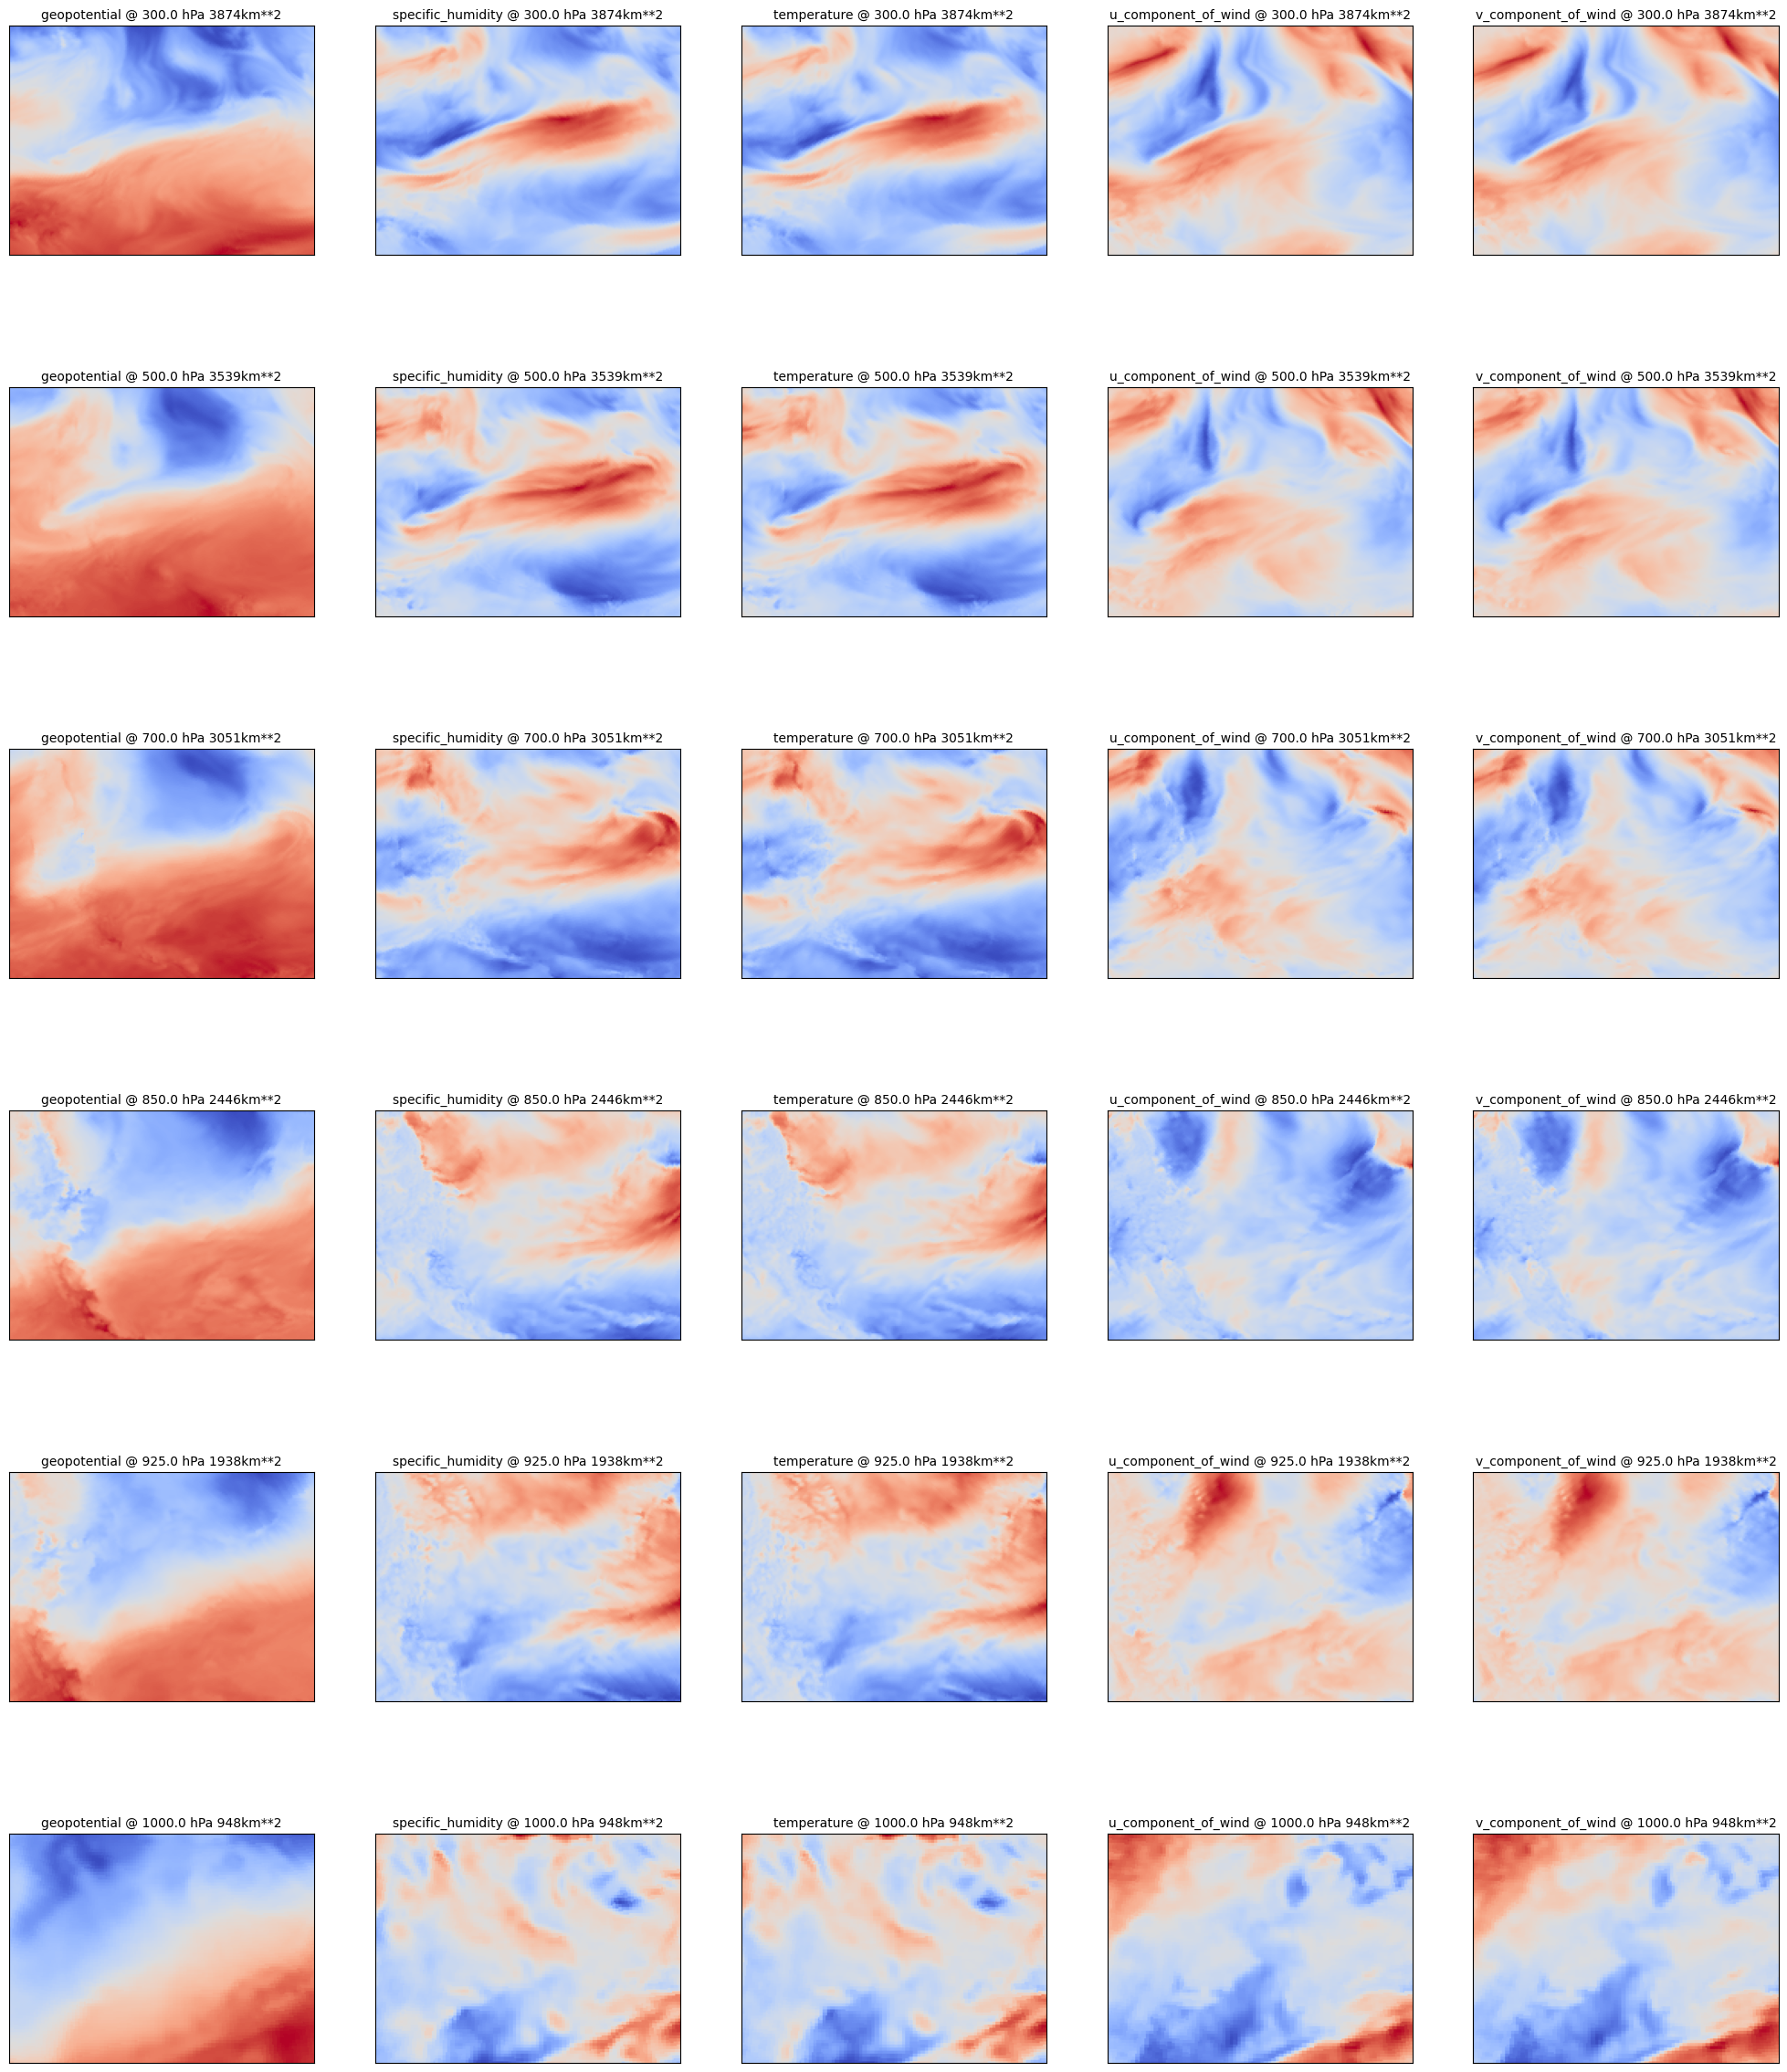

In [10]:
import matplotlib.pyplot as plt

data_vars = era5_dvars
levels = [1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]
e = np.abs(scale.stack_extent()[1:, 0])
fig, axes = plt.subplots(len(levels), len(era5_dvars), figsize=(5 * len(era5_dvars), 5 * len(levels)))
axes = axes[::-1]
for i, level in enumerate(levels):
    for j, dvar in enumerate(data_vars):
        ax = axes[i, j]
        ax.imshow(arr[locate(dvar, level, 1)], cmap="coolwarm")
        ax.set_title(f"{dvar} @ {level} hPa {int(e[i])}km**2", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])